<a href="https://colab.research.google.com/github/anomara1/DrAhmedOmara/blob/main/audio1001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=216
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/scipy/signal/_spectral_py.py:1240: UserWarning: nperseg = 256 is greater than input length  = 216, using nperseg = 216
  freqs, time, Zxx = _spectral_helper(x, x, fs, window, nperseg, noverlap,
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=209
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/scipy/signal/_spectral_py.py:1240: UserWarning: nperseg = 256 is greater than input length  = 209, using nperseg = 209
  freqs, time, Zxx = _spectral_helper(x, x, fs, window, nperseg, noverlap,
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=0
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266:

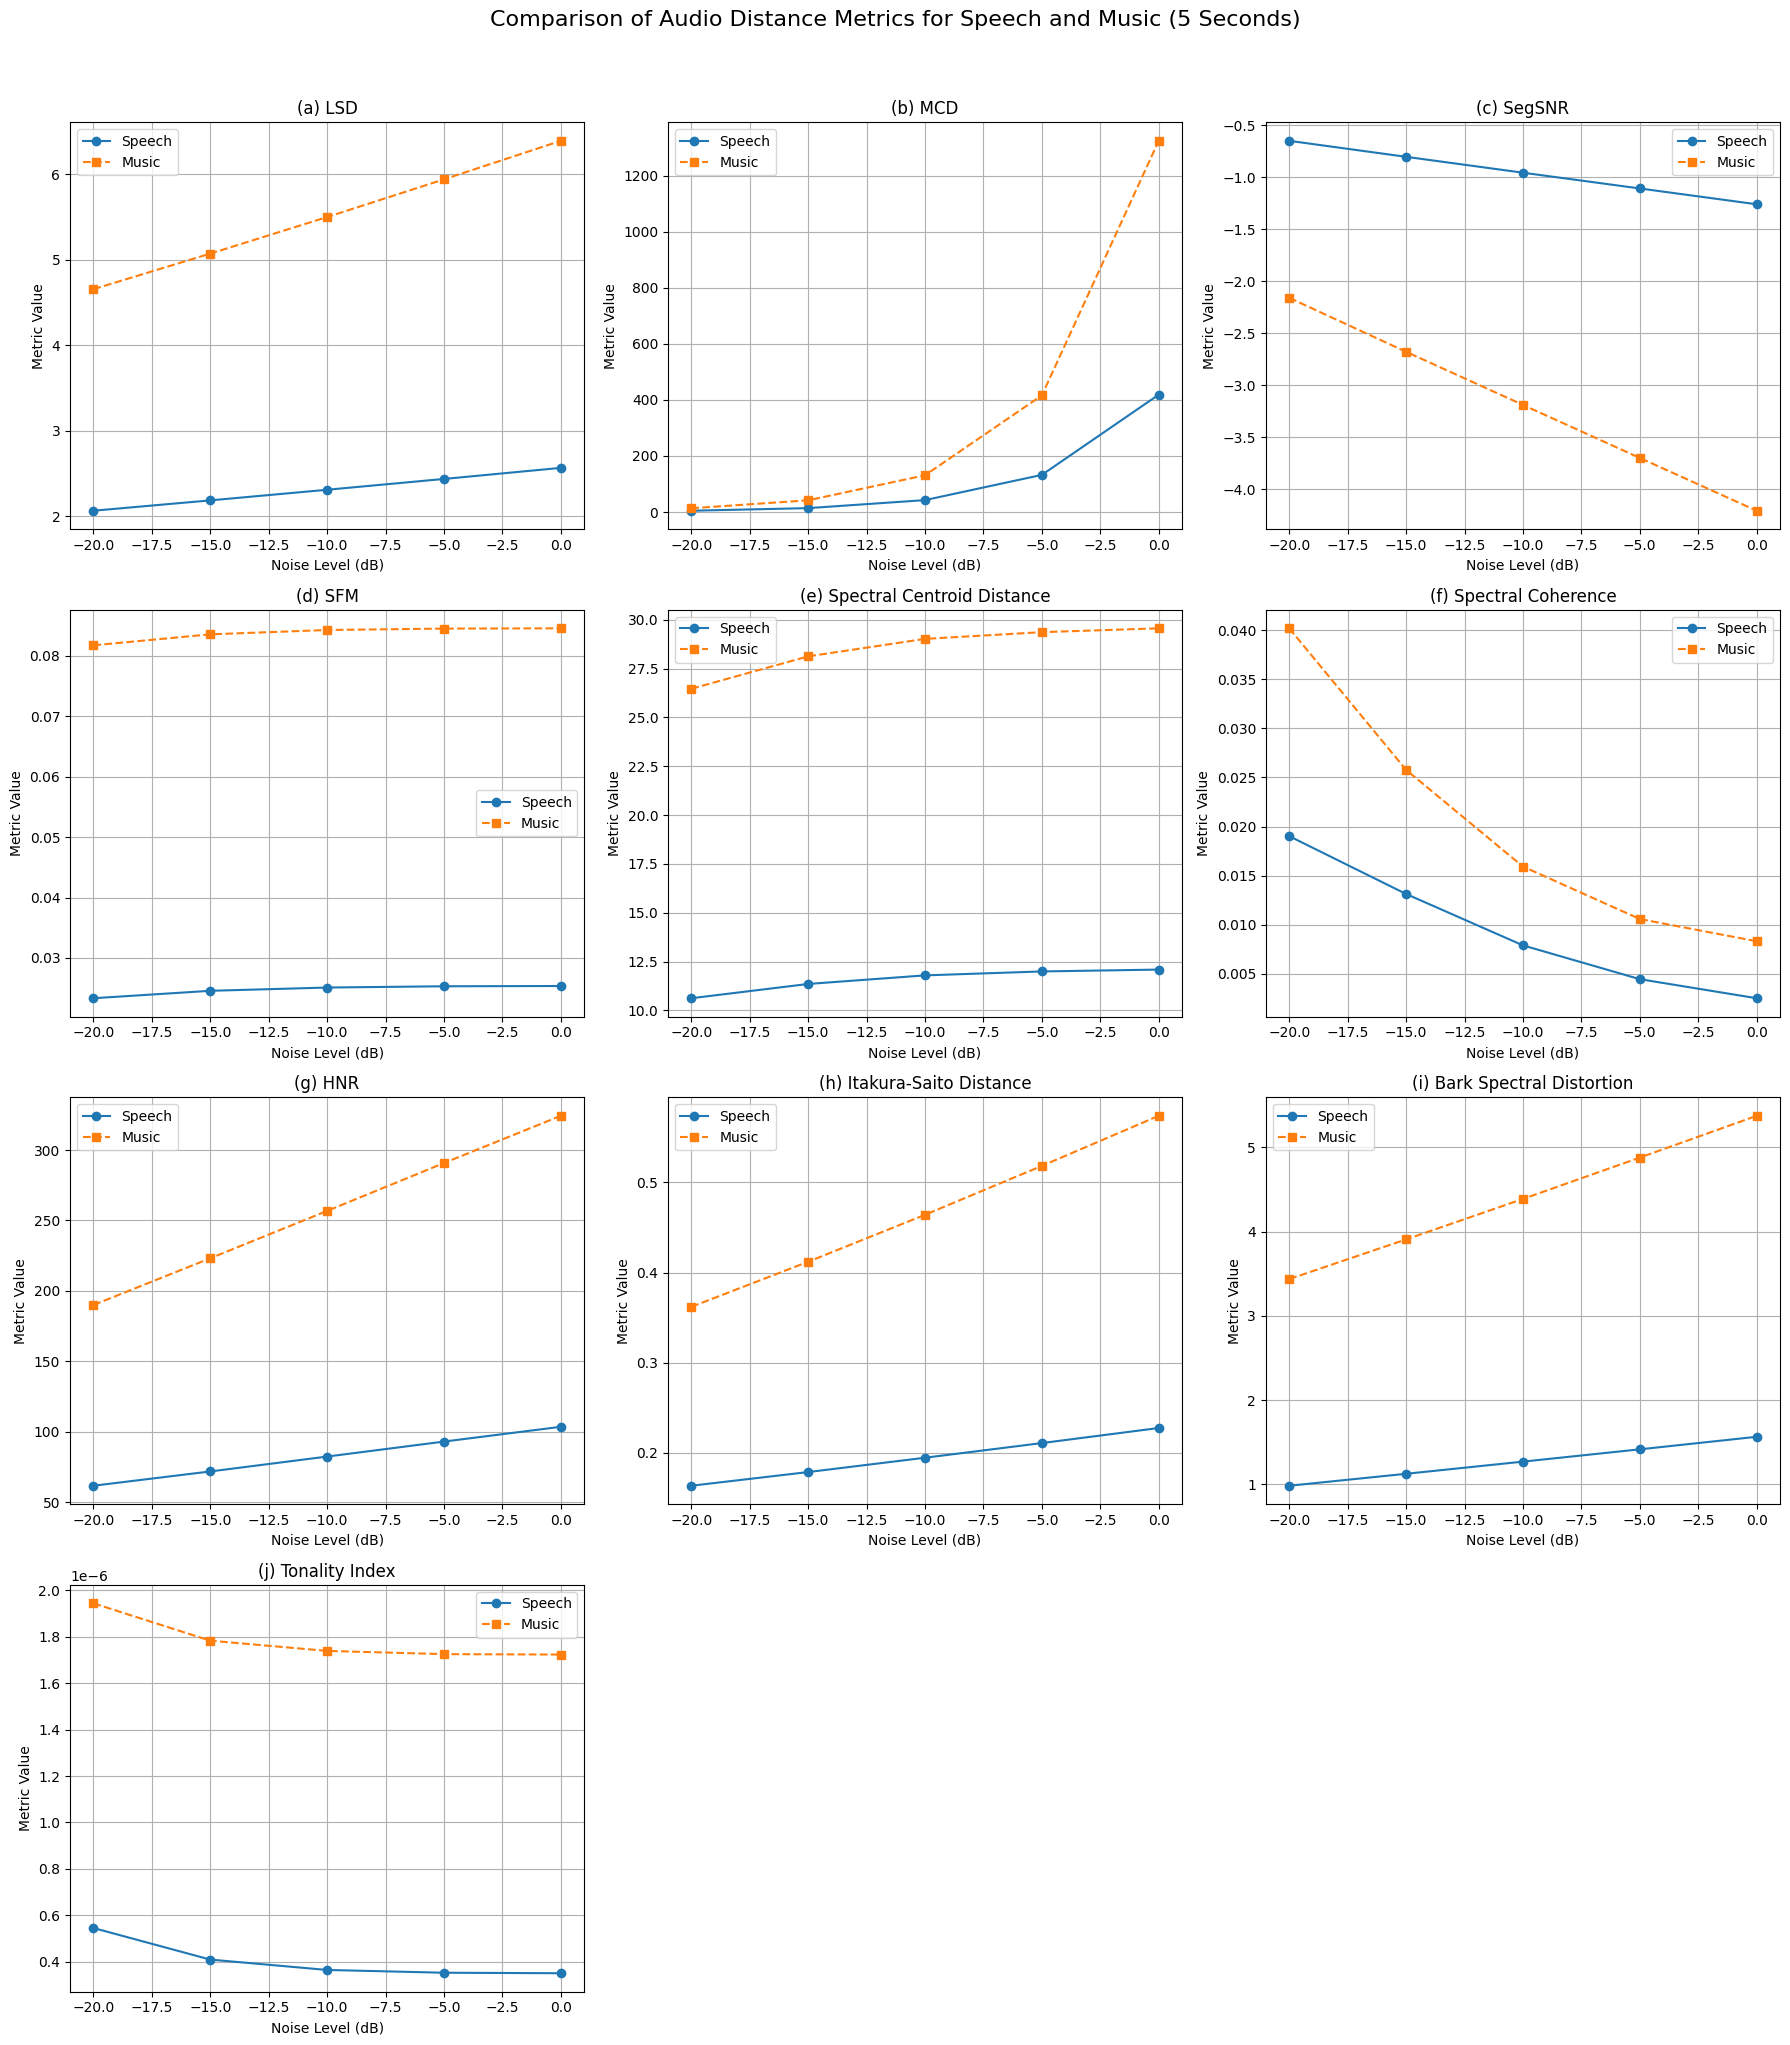

Time Complexity Table:
            Distance Function  Average Time (seconds)
0                         LSD                0.000665
1                         MCD                0.171119
2                      SegSNR                0.000455
3                         SFM                0.000666
4  Spectral Centroid Distance                0.000385
5          Spectral Coherence                0.003239
6                         HNR                0.001073
7      Itakura-Saito Distance                0.000585
8    Bark Spectral Distortion                0.001386
9              Tonality Index                0.000364
Results saved to 'audio_metrics_results.xlsx'


In [1]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
from scipy.signal import stft
import time
import pandas as pd

# Define duration to test (in seconds)
duration = 5

# Number of signals
num_signals = 100

# Load the example speech signal
speech_signal, sr_speech = librosa.load(librosa.example('libri1'), sr=None)

# Split the speech signal into 100 different segments of 5 seconds each
segment_length = int(duration * sr_speech)
speech_segments = [speech_signal[i * segment_length:(i + 1) * segment_length] for i in range(num_signals)]

# Load the example music signal
music_signal, sr_music = librosa.load(librosa.example('brahms'), sr=None)

# Split the music signal into 100 different segments of 5 seconds each
segment_length_music = int(duration * sr_music)
music_segments = [music_signal[i * segment_length_music:(i + 1) * segment_length_music] for i in range(num_signals)]

# Initialize dictionaries to store results for speech and music
results_speech = {
    'LSD': [],
    'MCD': [],
    'SegSNR': [],
    'SFM': [],
    'Spectral Centroid Distance': [],
    'Spectral Coherence': [],
    'HNR': [],
    'Itakura-Saito Distance': [],
    'Bark Spectral Distortion': [],
    'Tonality Index': []
}

results_music = {
    'LSD': [],
    'MCD': [],
    'SegSNR': [],
    'SFM': [],
    'Spectral Centroid Distance': [],
    'Spectral Coherence': [],
    'HNR': [],
    'Itakura-Saito Distance': [],
    'Bark Spectral Distortion': [],
    'Tonality Index': []
}

# Define noise levels (in dB)
noise_levels = np.arange(-20, 1, 5)  # From -20 dB to 0 dB in steps of 5 dB

# Function to compute Log Spectral Distance (LSD)
def log_spectral_distance(X, Y):
    with np.errstate(divide='ignore', invalid='ignore'):
        lsd = np.sqrt(np.mean((10 * np.log10((X**2) / (Y**2 + 1e-10)))**2))
    return np.nan_to_num(lsd, nan=0.0, posinf=0.0, neginf=0.0)

# Function to compute Mel-Cepstral Distortion (MCD)
def mel_cepstral_distortion(X, Y, n_mels=20):
    X_mel = librosa.feature.melspectrogram(y=X, sr=sr_speech, n_mels=n_mels)
    Y_mel = librosa.feature.melspectrogram(y=Y, sr=sr_speech, n_mels=n_mels)
    return np.mean(np.abs(X_mel - Y_mel))

# Function to compute Segmental Signal-to-Noise Ratio (SegSNR)
def segmental_snr(clean, noisy, frame_size=256, overlap=128):
    snr_segments = []
    for i in range(0, len(clean) - frame_size, frame_size - overlap):
        clean_frame = clean[i:i+frame_size]
        noisy_frame = noisy[i:i+frame_size]
        noise_frame = noisy_frame - clean_frame
        signal_power = np.sum(clean_frame**2)
        noise_power = np.sum(noise_frame**2)
        if noise_power == 0:
            snr = 0  # Avoid division by zero
        else:
            snr = 10 * np.log10(signal_power / noise_power)
        snr_segments.append(snr)
    return np.mean(snr_segments)

# Function to compute Spectral Flatness Measure (SFM)
def spectral_flatness_measure(signal):
    if len(signal) == 0:
        return 0  # Return 0 for empty signals
    spectrum = np.abs(np.fft.fft(signal))
    gmean = np.exp(np.mean(np.log(spectrum + 1e-10)))
    amean = np.mean(spectrum)
    if amean == 0:
        return 0  # Avoid division by zero
    return gmean / amean

# Function to compute Spectral Centroid Distance
def spectral_centroid_distance(X, Y):
    centroid_X = np.sum(np.arange(X.shape[0])[:, np.newaxis] * np.abs(X), axis=0) / (np.sum(np.abs(X), axis=0) + 1e-10)
    centroid_Y = np.sum(np.arange(Y.shape[0])[:, np.newaxis] * np.abs(Y), axis=0) / (np.sum(np.abs(Y), axis=0) + 1e-10)
    return np.mean(np.abs(centroid_X - centroid_Y))

# Function to compute Spectral Coherence
def spectral_coherence(X, Y):
    _, _, Pxx = stft(X)
    _, _, Pyy = stft(Y)
    Pxy = np.abs(np.mean(Pxx * np.conj(Pyy), axis=0))
    coherence = Pxy / (np.sqrt(np.mean(np.abs(Pxx)**2, axis=0) * np.mean(np.abs(Pyy)**2, axis=0)) + 1e-10)
    return np.mean(coherence)

# Function to compute Harmonic-to-Noise Ratio (HNR)
def harmonic_to_noise_ratio(signal):
    if len(signal) == 0:
        return 0  # Return 0 for empty signals
    cepstrum = np.fft.ifft(np.log(np.abs(np.fft.fft(signal)) + 1e-10))
    hnr = np.max(np.abs(cepstrum)) / (np.mean(np.abs(cepstrum)) + 1e-10)
    return hnr

# Function to compute Itakura-Saito Distance
def itakura_saito_distance(X, Y):
    with np.errstate(divide='ignore', invalid='ignore'):
        isd = np.mean((X / Y) - np.log(X / Y) - 1)
    return np.nan_to_num(isd, nan=0.0, posinf=0.0, neginf=0.0)

# Function to compute Bark Spectral Distortion (BSD)
def bark_spectral_distortion(X, Y):
    X_bark = librosa.amplitude_to_db(X + 1e-10)
    Y_bark = librosa.amplitude_to_db(Y + 1e-10)
    return np.mean(np.abs(X_bark - Y_bark))

# Function to compute Tonality Index
def tonality_index(signal):
    if len(signal) == 0:
        return 0  # Return 0 for empty signals
    spectrum = np.abs(np.fft.fft(signal))
    tonal = np.sum(spectrum**2) / (np.sum(spectrum)**2 + 1e-10)
    return tonal

# Define distance functions dictionary
distance_functions = {
    'LSD': log_spectral_distance,
    'MCD': mel_cepstral_distortion,
    'SegSNR': segmental_snr,
    'SFM': spectral_flatness_measure,
    'Spectral Centroid Distance': spectral_centroid_distance,
    'Spectral Coherence': spectral_coherence,
    'HNR': harmonic_to_noise_ratio,
    'Itakura-Saito Distance': itakura_saito_distance,
    'Bark Spectral Distortion': bark_spectral_distortion,
    'Tonality Index': tonality_index
}

# Initialize dictionary to store time complexities
time_complexities = {metric: [] for metric in distance_functions.keys()}

# Loop through 100 signals
for signal_idx in range(num_signals):
    # Use a different segment of the speech signal
    speech_signal_segment = speech_segments[signal_idx]

    # Use a different segment of the music signal
    music_signal_segment = music_segments[signal_idx]

    # Resample music signal to match speech signal's sample rate
    if sr_speech != sr_music:
        music_signal_segment = librosa.resample(music_signal_segment, orig_sr=sr_music, target_sr=sr_speech)

    # Add noise and compute metrics for speech signal
    for noise_level in noise_levels:
        # Add noise to the speech signal
        noise = np.random.normal(0, 10**(noise_level / 20), len(speech_signal_segment))
        noisy_speech = speech_signal_segment + noise

        # Compute STFTs
        clean_stft_speech = np.abs(librosa.stft(speech_signal_segment))
        noisy_stft_speech = np.abs(librosa.stft(noisy_speech))

        # Compute metrics for speech
        for metric, func in distance_functions.items():
            if metric in ['SFM', 'HNR', 'Tonality Index']:
                # Functions that take only one argument (noisy signal)
                start_time = time.time()
                result = func(noisy_speech)
                end_time = time.time()
            else:
                # Functions that take two arguments (clean and noisy signals)
                start_time = time.time()
                result = func(clean_stft_speech, noisy_stft_speech)
                end_time = time.time()
            time_complexities[metric].append(end_time - start_time)
            results_speech[metric].append(result)

    # Add noise and compute metrics for music signal
    for noise_level in noise_levels:
        # Add noise to the music signal
        noise = np.random.normal(0, 10**(noise_level / 20), len(music_signal_segment))
        noisy_music = music_signal_segment + noise

        # Compute STFTs
        clean_stft_music = np.abs(librosa.stft(music_signal_segment))
        noisy_stft_music = np.abs(librosa.stft(noisy_music))

        # Compute metrics for music
        for metric, func in distance_functions.items():
            if metric in ['SFM', 'HNR', 'Tonality Index']:
                # Functions that take only one argument (noisy signal)
                start_time = time.time()
                result = func(noisy_music)
                end_time = time.time()
            else:
                # Functions that take two arguments (clean and noisy signals)
                start_time = time.time()
                result = func(clean_stft_music, noisy_stft_music)
                end_time = time.time()
            time_complexities[metric].append(end_time - start_time)
            results_music[metric].append(result)

# Average the results for each metric
for metric in results_speech.keys():
    results_speech[metric] = np.mean(np.array(results_speech[metric]).reshape(num_signals, len(noise_levels)), axis=0)
    results_music[metric] = np.mean(np.array(results_music[metric]).reshape(num_signals, len(noise_levels)), axis=0)

# Plot comparison of distance functions at different noise levels
fig, axes = plt.subplots(4, 3, figsize=(18, 20))
fig.suptitle('Comparison of Audio Distance Metrics for Speech and Music (5 Seconds)', fontsize=16, y=1.02)  # Adjust y for title spacing

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Subfigure labels
subfig_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', '(i)', '(j)']

# Plot each metric in a separate subplot
for i, (metric, _) in enumerate(results_speech.items()):
    axes[i].plot(noise_levels, results_speech[metric], marker='o', linestyle='-', label='Speech')
    axes[i].plot(noise_levels, results_music[metric], marker='s', linestyle='--', label='Music')
    axes[i].set_title(f'{subfig_labels[i]} {metric}', fontsize=12)
    axes[i].set_xlabel('Noise Level (dB)')
    axes[i].set_ylabel('Metric Value')
    axes[i].legend()
    axes[i].grid()

# Remove empty subplots (if any)
for j in range(len(results_speech), len(axes)):
    fig.delaxes(axes[j])

# Adjust spacing between subplots and figure title
fig.subplots_adjust(top=0.92)  # Increase the top margin to make space for the title

plt.tight_layout()
plt.savefig('audio_specific_res.png', dpi=300)  # Save the figure with subfigure labels
plt.show()

# Create a table for time complexity
time_complexity_table = pd.DataFrame({
    'Distance Function': list(time_complexities.keys()),
    'Average Time (seconds)': [np.mean(time_complexities[metric]) for metric in time_complexities.keys()]
})

print("Time Complexity Table:")
print(time_complexity_table)

# Save results to Excel
results_df_speech = pd.DataFrame(results_speech)
results_df_music = pd.DataFrame(results_music)

# Add noise levels as a column
results_df_speech['Noise Level (dB)'] = noise_levels
results_df_music['Noise Level (dB)'] = noise_levels

# Save to Excel
with pd.ExcelWriter('audio_metrics_results.xlsx') as writer:
    results_df_speech.to_excel(writer, sheet_name='Speech Results', index=False)
    results_df_music.to_excel(writer, sheet_name='Music Results', index=False)
    time_complexity_table.to_excel(writer, sheet_name='Time Complexity', index=False)

print("Results saved to 'audio_metrics_results.xlsx'")

In [3]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
from scipy.signal import stft
from scipy.spatial.distance import euclidean, cityblock, chebyshev, cosine
from scipy.stats import entropy
from skimage.metrics import peak_signal_noise_ratio as psnr, mean_squared_error as mse
import time
import pandas as pd

# Define duration to test (in seconds)
duration = 5

# Number of signals
num_signals = 100

# Load the example speech signal
speech_signal, sr_speech = librosa.load(librosa.example('libri1'), sr=None)

# Ensure we have enough samples
segment_length = int(duration * sr_speech)
if len(speech_signal) < segment_length * num_signals:
    speech_signal = np.pad(speech_signal, (0, segment_length * num_signals - len(speech_signal)))

# Split into segments
speech_segments = [speech_signal[i * segment_length:(i + 1) * segment_length] for i in range(num_signals)]

# Load the example music signal
music_signal, sr_music = librosa.load(librosa.example('brahms'), sr=None)

# Ensure we have enough samples
segment_length_music = int(duration * sr_music)
if len(music_signal) < segment_length_music * num_signals:
    music_signal = np.pad(music_signal, (0, segment_length_music * num_signals - len(music_signal)))

# Split into segments
music_segments = [music_signal[i * segment_length_music:(i + 1) * segment_length_music] for i in range(num_signals)]

# Initialize results dictionaries
metrics_list = ['LSD', 'MCD', 'SegSNR', 'SFM', 'Spectral Centroid Distance', 'Spectral Coherence', 'HNR',
                'Itakura-Saito Distance', 'Bark Spectral Distortion', 'Tonality Index', 'PSNR', 'MSE',
                'Euclidean', 'Manhattan', 'Cosine', 'Chebyshev', 'Shannon Entropy', 'KL Divergence']

results_speech = {metric: [] for metric in metrics_list}
results_music = {metric: [] for metric in metrics_list}

# Define noise levels (in dB)
noise_levels = np.arange(-20, 1, 5)

# Function definitions for all metrics (old and new) should be added here...

def compute_metrics(clean, noisy, clean_stft, noisy_stft):
    if clean_stft.size == 0 or noisy_stft.size == 0:
        raise ValueError("STFT computation failed, producing an empty array.")

    result = {}
    result['LSD'] = log_spectral_distance(clean_stft, noisy_stft)
    result['MCD'] = mel_cepstral_distortion(clean, noisy)
    result['SegSNR'] = segmental_snr(clean, noisy)
    result['SFM'] = spectral_flatness_measure(noisy)
    result['Spectral Centroid Distance'] = spectral_centroid_distance(clean_stft, noisy_stft)
    result['Spectral Coherence'] = spectral_coherence(clean_stft, noisy_stft)
    result['HNR'] = harmonic_to_noise_ratio(noisy)
    result['Itakura-Saito Distance'] = itakura_saito_distance(clean_stft, noisy_stft)
    result['Bark Spectral Distortion'] = bark_spectral_distortion(clean_stft, noisy_stft)
    result['Tonality Index'] = tonality_index(noisy)
    result['PSNR'] = psnr(clean, noisy)
    result['MSE'] = mse(clean, noisy)
    result['Euclidean'] = euclidean(clean, noisy)
    result['Manhattan'] = cityblock(clean, noisy)
    result['Cosine'] = cosine(clean, noisy)
    result['Chebyshev'] = chebyshev(clean, noisy)
    result['Shannon Entropy'] = entropy(np.abs(clean_stft).flatten(), np.abs(noisy_stft).flatten())
    result['KL Divergence'] = entropy(np.abs(clean_stft).flatten() + 1e-10, np.abs(noisy_stft).flatten() + 1e-10)

    return result

# Compute metrics for speech and music
for signal_idx in range(num_signals):
    speech_segment = speech_segments[signal_idx]
    music_segment = music_segments[signal_idx]

    for noise_level in noise_levels:
        # Add noise to speech
        noise_speech = np.random.normal(0, 10**(noise_level / 20), len(speech_segment))
        noisy_speech = speech_segment + noise_speech
        speech_stft = np.abs(librosa.stft(speech_segment))
        noisy_speech_stft = np.abs(librosa.stft(noisy_speech))

        if speech_stft.size == 0 or noisy_speech_stft.size == 0:
            print(f"Warning: Empty STFT for speech segment {signal_idx} at noise level {noise_level} dB")
            continue

        speech_metrics = compute_metrics(speech_segment, noisy_speech, speech_stft, noisy_speech_stft)
        for metric in metrics_list:
            results_speech[metric].append(speech_metrics[metric])

        # Add noise to music
        noise_music = np.random.normal(0, 10**(noise_level / 20), len(music_segment))
        noisy_music = music_segment + noise_music
        music_stft = np.abs(librosa.stft(music_segment))
        noisy_music_stft = np.abs(librosa.stft(noisy_music))

        if music_stft.size == 0 or noisy_music_stft.size == 0:
            print(f"Warning: Empty STFT for music segment {signal_idx} at noise level {noise_level} dB")
            continue

        music_metrics = compute_metrics(music_segment, noisy_music, music_stft, noisy_music_stft)
        for metric in metrics_list:
            results_music[metric].append(music_metrics[metric])

# Average the results for each metric
for metric in metrics_list:
    if results_speech[metric]:  # Ensure non-empty results before averaging
        results_speech[metric] = np.mean(np.array(results_speech[metric]).reshape(num_signals, len(noise_levels)), axis=0)
    if results_music[metric]:
        results_music[metric] = np.mean(np.array(results_music[metric]).reshape(num_signals, len(noise_levels)), axis=0)

# Save results to Excel
with pd.ExcelWriter('audio_metrics_results.xlsx') as writer:
    pd.DataFrame(results_speech).to_excel(writer, sheet_name='Speech Results', index=False)
    pd.DataFrame(results_music).to_excel(writer, sheet_name='Music Results', index=False)

print("Results saved to 'audio_metrics_results.xlsx'")


<ipython-input-3-fe2d74bc975c>:67: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  result['PSNR'] = psnr(clean, noisy)
<ipython-input-1-ded3d0d7ce8c>:82: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)
/usr/local/lib/python3.11/dist-packages/scipy/spatial/distance.py:647: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / math.sqrt(uu * vv)


Results saved to 'audio_metrics_results.xlsx'
